In [ ]:
import pathlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from pathlib import Path
import random
from PIL import Image
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [ ]:
train_dir = 'E:/Data Sets/Skin_Cancer/train'
test_dir = 'E:/Data Sets/Skin_Cancer/test'
class_names = os.listdir(train_dir)
class_types = len(os.listdir('E:/Data Sets/Skin_Cancer/train'))
print('Number of classes for Classification: ',class_types)
print(f'The class names are {class_names[0]} and {class_names[1]}')
print('--> Count of Train Images <--')
for i in class_names:
    print(i + ':' + str(len(os.listdir('E:/Data Sets/Skin_Cancer/train/'+i))))
print('--> Count of Test Images <--')
for i in class_names:
    print(i + ':' + str(len(os.listdir('E:/Data Sets/Skin_Cancer/test/'+i))))

Number of classes for Classification:  2
The class names are benign and malignant
--> Count of Train Images <--
benign:1440
malignant:1197
--> Count of Test Images <--
benign:360
malignant:300


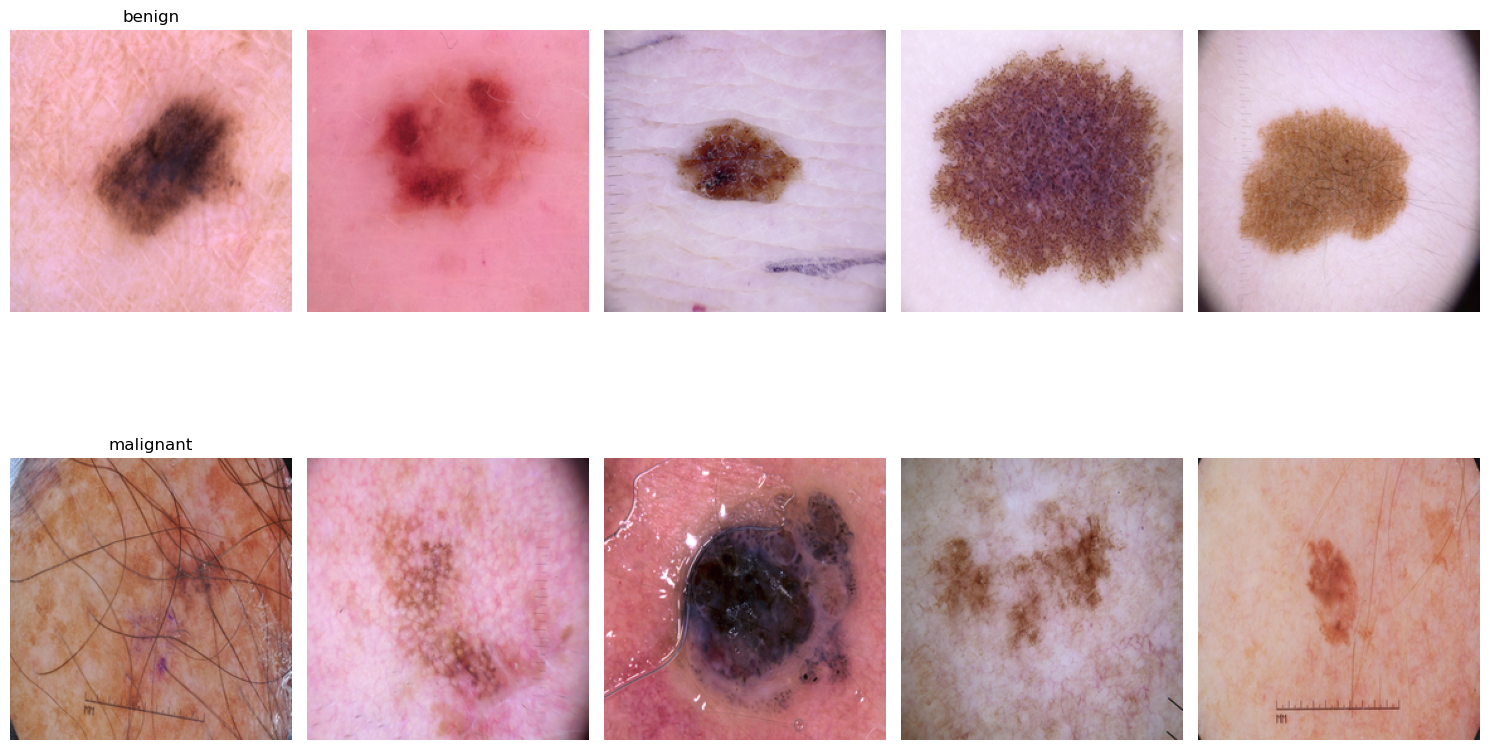

In [ ]:
# Function to plot random images from each class
def plot_random_images(train_dir, class_names, num_images=5):
    plt.figure(figsize=(15, 10))

    # Iterate through each class
    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        image_files = os.listdir(class_dir)

        # Randomly select images
        random_images = random.sample(image_files, num_images)

        # Plot the images
        for i, image_file in enumerate(random_images):
            plt.subplot(len(class_names), num_images, num_images * class_names.index(class_name) + i + 1)
            img_path = os.path.join(class_dir, image_file)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            if i == 0:
                plt.title(class_name)

    plt.tight_layout()
    plt.show()

# Call the function to plot random images
plot_random_images(train_dir, class_names)

In [ ]:
# Define image dimensions
img_width, img_height = 128, 128

# Create ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0,1]
    shear_range=0.2,            # Shear Intensity
    zoom_range=0.2,             # Random Zoom
    horizontal_flip=True,       # Random Horizontal Flip
    rotation_range=40,          # Random Rotation
    width_shift_range=0.2,      # Random Width Shift
    height_shift_range=0.2,     # Random Height Shift
    fill_mode='nearest'         # Fill mode for filling in newly created pixels
)

In [ ]:
# Create ImageDataGenerator for testing data (only normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow images from directory in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'         # Since this is a binary classification problem
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'         # Since this is a binary classification problem
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


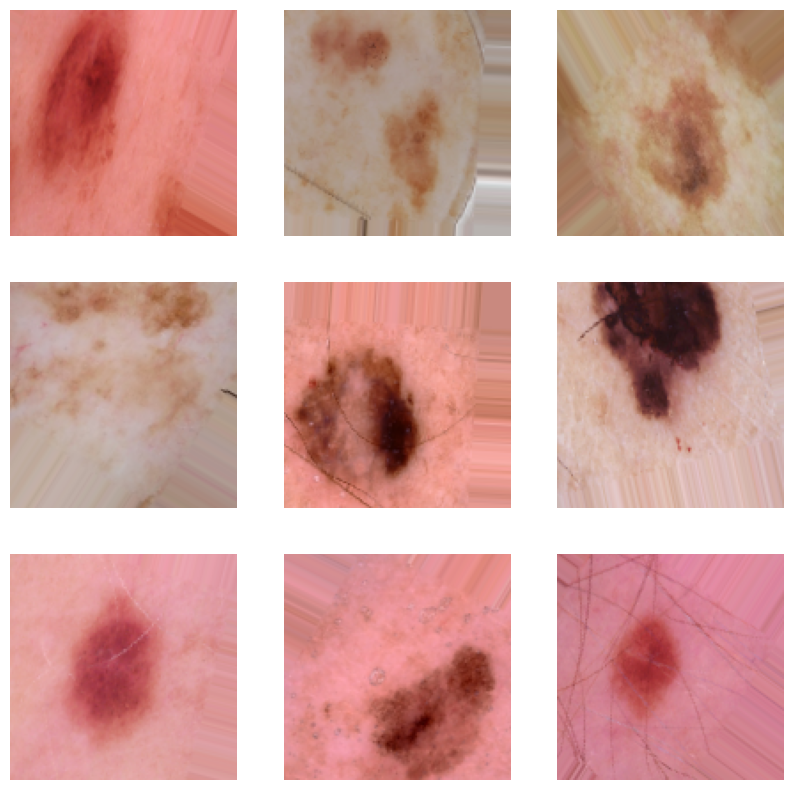

In [ ]:
# Display sample images after augmentation
sample_batch = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_batch[0][i])
    plt.axis('off')
plt.show()

In [ ]:
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [ ]:
test_df = loading_the_data(test_dir)
test_df

,filepaths,labels
0,E:/Data Sets/Skin_Cancer/test\benign\1.jpg,benign
1,E:/Data Sets/Skin_Cancer/test\benign\10.jpg,benign
2,E:/Data Sets/Skin_Cancer/test\benign\1003.jpg,benign
3,E:/Data Sets/Skin_Cancer/test\benign\1006.jpg,benign
4,E:/Data Sets/Skin_Cancer/test\benign\1013.jpg,benign
...,...,...
655,E:/Data Sets/Skin_Cancer/test\malignant\953.jpg,malignant
656,E:/Data Sets/Skin_Cancer/test\malignant\985.jpg,malignant
657,E:/Data Sets/Skin_Cancer/test\malignant\992.jpg,malignant
658,E:/Data Sets/Skin_Cancer/test\malignant\994.jpg,malignant


In [ ]:
train_df = loading_the_data(train_dir)

train_df

,filepaths,labels
0,E:/Data Sets/Skin_Cancer/train\benign\100.jpg,benign
1,E:/Data Sets/Skin_Cancer/train\benign\1000.jpg,benign
2,E:/Data Sets/Skin_Cancer/train\benign\1001.jpg,benign
3,E:/Data Sets/Skin_Cancer/train\benign\1002.jpg,benign
4,E:/Data Sets/Skin_Cancer/train\benign\1004.jpg,benign
...,...,...
2632,E:/Data Sets/Skin_Cancer/train\malignant\993.jpg,malignant
2633,E:/Data Sets/Skin_Cancer/train\malignant\996.jpg,malignant
2634,E:/Data Sets/Skin_Cancer/train\malignant\997.jpg,malignant
2635,E:/Data Sets/Skin_Cancer/train\malignant\998.jpg,malignant


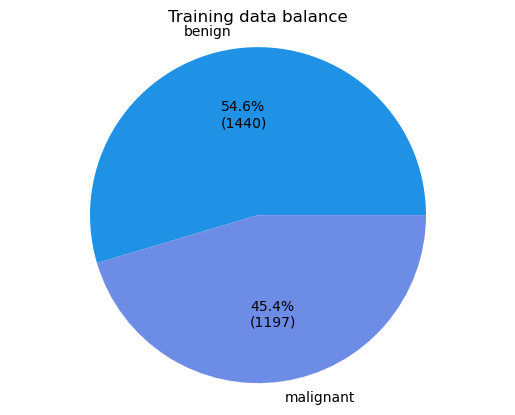

In [ ]:
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [ ]:
# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# Create a new model on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
batch_size = 32

# Calculate the total number of training samples
total_training_samples = sum(len(files) for _, _, files in os.walk(train_dir))

# Calculate the number of steps per epoch
steps_per_epoch = total_training_samples // batch_size

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Increase the number of epochs
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping]  # Pass the early stopping callback
)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.5726 - loss: 0.6838 - val_accuracy: 0.5455 - val_loss: 0.6897
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5000 - loss: 0.3529 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.5462 - loss: 0.6884 - val_accuracy: 0.5455 - val_loss: 0.6885


In [ ]:
# Custom CNN model
model2 = Sequential([
    # First convolutional layer with 32 filters and ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),

    # Second convolutional layer with 64 filters and ReLU activation
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer with 128 filters and ReLU activation
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Fourth convolutional layer with 256 filters and ReLU activation
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten layer to convert 3D feature maps to 1D feature vectors
    Flatten(),

    # First dense layer with 512 neurons and ReLU activation
    Dense(512, activation='relu'),

    # Second dense layer with 512 neurons and ReLU activation
    Dense(512, activation='relu'),

    # Dropout layer to prevent overfitting
    Dropout(0.5),

    # Output layer with 1 neuron and sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

C:\Users\PRIYANSHU\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Summary of the model architecture
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,370,689 (20.49 MB)

 Trainable params: 5,370,689 (20.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history2 = model2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping]
)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 312ms/step - accuracy: 0.8071 - loss: 0.3889 - val_accuracy: 0.8000 - val_loss: 0.3779
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.8438 - loss: 0.1766 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10


C:\Users\PRIYANSHU\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 0.8048 - loss: 0.3857 - val_accuracy: 0.8061 - val_loss: 0.3959
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.8125 - loss: 0.1666 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 288ms/step - accuracy: 0.8057 - loss: 0.4111 - val_accuracy: 0.8061 - val_loss: 0.3940
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.9062 - loss: 0.1780 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - accuracy: 0.7956 - loss: 0.4043 - val_accuracy: 0.8000 - val_loss: 0.3869


In [ ]:
# Evaluate model
model_scores = model.evaluate(test_generator, steps=len(test_generator))
print("Metrics for model:")
print("Test Loss:", model_scores[0])
print("Test Accuracy:", model_scores[1])

21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 905ms/step - accuracy: 0.5350 - loss: 0.6910
Metrics for model:
Test Loss: 0.6896506547927856
Test Accuracy: 0.5454545617103577


In [ ]:
# Predictions for model
model_predictions = model.predict(test_generator)
model_predictions = np.round(model_predictions)

21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


In [ ]:
# Classification report for model
print("\nClassification Report for model:")
print(classification_report(test_generator.classes, model_predictions))


Classification Report for model:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       360
           1       0.00      0.00      0.00       300

    accuracy                           0.55       660
   macro avg       0.27      0.50      0.35       660
weighted avg       0.30      0.55      0.39       660



C:\Users\PRIYANSHU\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRIYANSHU\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRIYANSHU\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


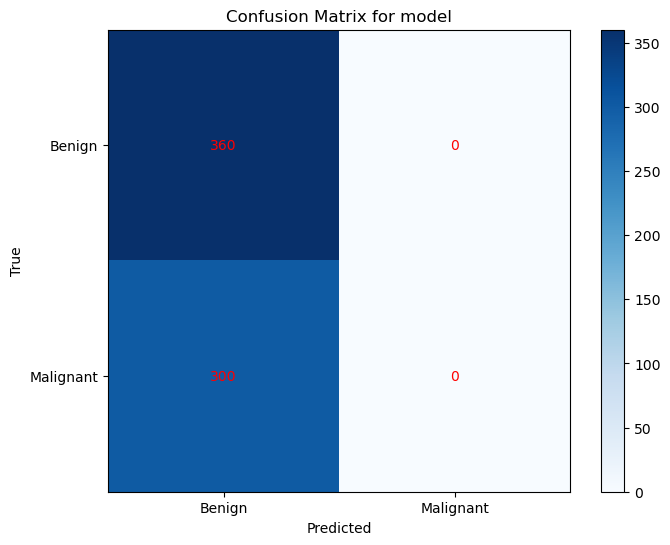

In [ ]:
# Confusion matrix for model
model_cm = confusion_matrix(test_generator.classes, model_predictions)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix for model')
plt.imshow(model_cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.yticks([0, 1], ['Benign', 'Malignant'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(model_cm[i, j]), ha='center', va='center', color='red')
plt.show()

In [ ]:
# Evaluate model2
model2_scores = model2.evaluate(test_generator, steps=len(test_generator))
print("Metrics for model2:")
print("Test Loss:", model2_scores[0])
print("Test Accuracy:", model2_scores[1])

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7983 - loss: 0.3890
Metrics for model2:
Test Loss: 0.37906426191329956
Test Accuracy: 0.7969697117805481


In [ ]:
# Predictions for model2
model2_predictions = model2.predict(test_generator)
model2_predictions = np.round(model2_predictions)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


In [ ]:
# Classification report for model2
print("\nClassification Report for model2:")
print(classification_report(test_generator.classes, model2_predictions))


Classification Report for model2:
              precision    recall  f1-score   support

           0       0.54      0.37      0.44       360
           1       0.45      0.62      0.52       300

    accuracy                           0.48       660
   macro avg       0.50      0.50      0.48       660
weighted avg       0.50      0.48      0.48       660



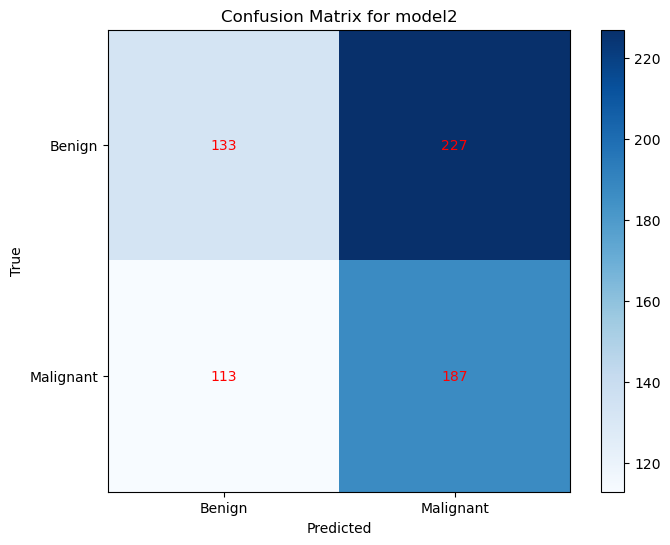

In [ ]:
# Confusion matrix for model2
model2_cm = confusion_matrix(test_generator.classes, model2_predictions)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix for model2')
plt.imshow(model2_cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.yticks([0, 1], ['Benign', 'Malignant'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(model2_cm[i, j]), ha='center', va='center', color='red')
plt.show()

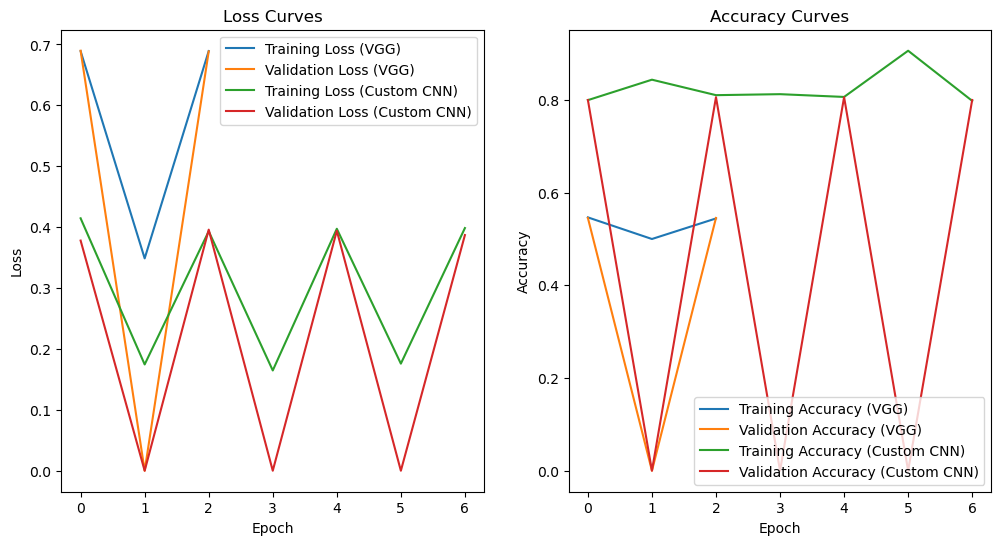

In [ ]:
# Comparision
# Plotting loss and accuracy curves during training
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (VGG)')
plt.plot(history.history['val_loss'], label='Validation Loss (VGG)')
plt.plot(history2.history['loss'], label='Training Loss (Custom CNN)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Custom CNN)')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy (VGG)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (VGG)')
plt.plot(history2.history['accuracy'], label='Training Accuracy (Custom CNN)')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy (Custom CNN)')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Comparing traditional metrics
def print_metrics(name, true, pred):
    print("Metrics for", name)
    print("Accuracy:", accuracy_score(true, pred))
    print("Precision:", precision_score(true, pred))
    print("Recall:", recall_score(true, pred))
    print("F1 Score:", f1_score(true, pred))
    print("ROC AUC Score:", roc_auc_score(true, pred))
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

print_metrics("VGG Model", test_generator.classes, np.round(model.predict(test_generator)))
print()
print_metrics("Custom CNN Model", test_generator.classes, np.round(model2.predict(test_generator)))

21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 882ms/step
Metrics for VGG Model
Accuracy: 0.5454545454545454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5
Specificity: 1.0



C:\Users\PRIYANSHU\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
Metrics for Custom CNN Model
Accuracy: 0.48484848484848486
Precision: 0.45169082125603865
Recall: 0.6233333333333333
F1 Score: 0.5238095238095238
ROC AUC Score: 0.4963888888888889
Specificity: 0.36944444444444446


21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 901ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


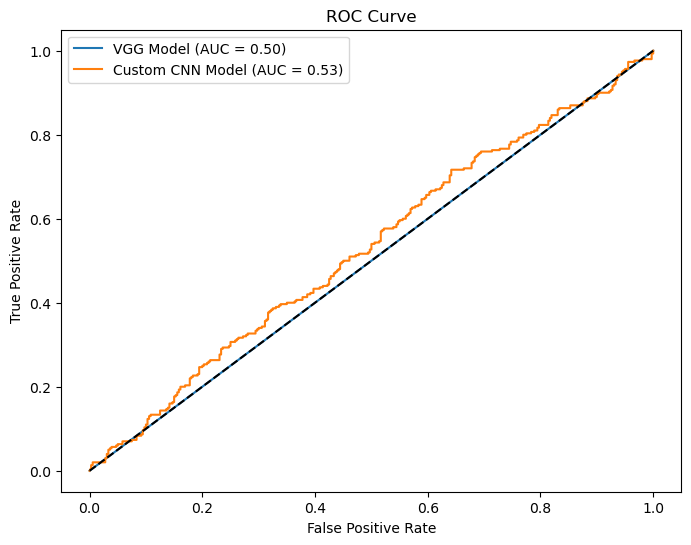

In [ ]:
# Presenting ROC curves
fpr_vgg, tpr_vgg, _ = roc_curve(test_generator.classes, model.predict(test_generator))
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

fpr_custom, tpr_custom, _ = roc_curve(test_generator.classes, model2.predict(test_generator))
roc_auc_custom = auc(fpr_custom, tpr_custom)

plt.figure(figsize=(8, 6))
plt.plot(fpr_vgg, tpr_vgg, label=f'VGG Model (AUC = {roc_auc_vgg:.2f})')
plt.plot(fpr_custom, tpr_custom, label=f'Custom CNN Model (AUC = {roc_auc_custom:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


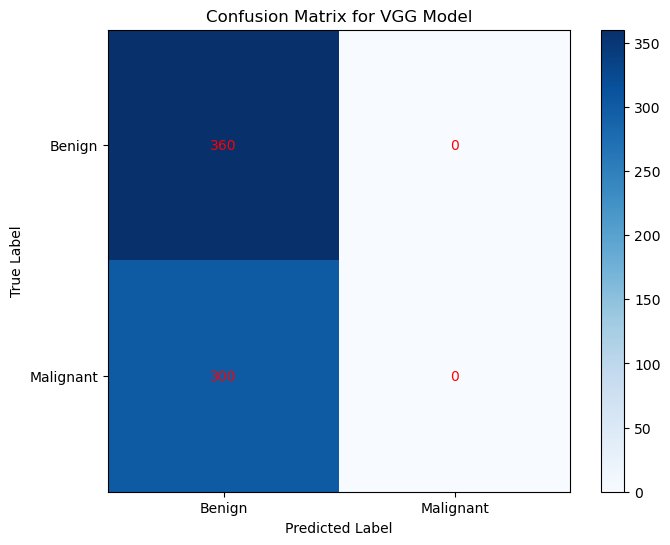

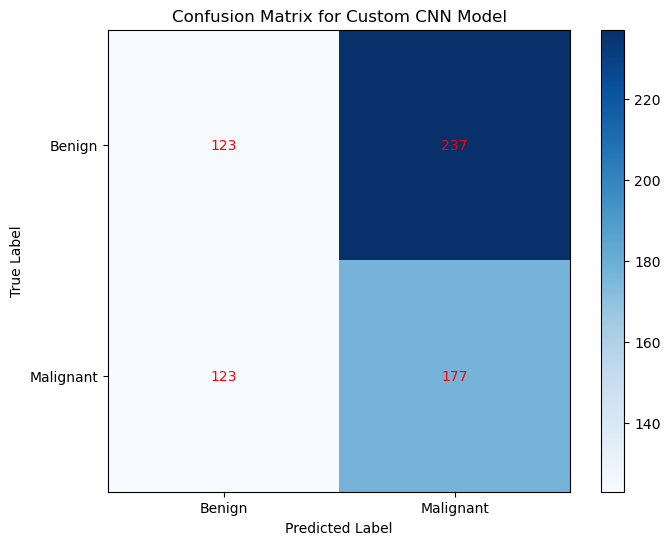

In [ ]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks([0, 1], ['Benign', 'Malignant'])
    plt.yticks([0, 1], ['Benign', 'Malignant'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red')
    plt.show()

cm_vgg = confusion_matrix(test_generator.classes, np.round(model.predict(test_generator)))
cm_custom = confusion_matrix(test_generator.classes, np.round(model2.predict(test_generator)))

plot_confusion_matrix(cm_vgg, title='Confusion Matrix for VGG Model')
plot_confusion_matrix(cm_custom, title='Confusion Matrix for Custom CNN Model')